# Demo

This notebook is provided to describe the usage of pydpac using a one-dimensional toy model known as [the Lorenz (1996) model](https://doi.org/10.1175/1520-0469(1998)055%3C0399:OSFSWO%3E2.0.CO;2) described by the following equation.
$$
\frac{dX_j}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_j + F
$$

## Available DA algorithms

A data assimilation (DA) algorithm can be chosen from the followings.

- Kalman Filter ([Kalman 1960](https://doi.org/10.1115/1.3662552))
- 3DVar, 4DVar ([Talagrand and Courtier 1987](https://doi.org/10.1002/qj.49711347812))
- Ensemble Kalman Filter([Evensen 1994](https://doi.org/10.1029/94JC00572))
 * ETKF ([Bishop et al. 2001](https://doi.org/10.1175/1520-0493(2001)129%3C0420:ASWTET%3E2.0.CO;2))
 * PO ([Burgers et al. 1998](https://doi.org/10.1175/1520-0493(1998)126%3C1719:ASITEK%3E2.0.CO;2), [Houtekamer et al.2005](https://doi.org/10.1175/MWR-2864.1))
 * EnSRF ([Whitaker and Hamill 2002](https://doi.org/10.1175/1520-0493(2002)130%3C1913:EDAWPO%3E2.0.CO;2))
 * LETKF ([Hunt et al. 2007](https://doi.org/10.1016/j.physd.2006.11.008))
- Maximum Likelihoon Ensemble Filter ([Zupanski 2005](https://doi.org/10.1175/MWR2946.1), [Zupanski et al. 2008](https://doi.org/10.1002/qj.251))

## Requirements

- numpy for the model and DA
- pandas for error statistics
- matplotlib for plots

## Usage

Execute the cells below sequentially.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.lorenz import L96
from analysis.obs import Obs

In [2]:
# model parameter
#model = "l96"

global nx, F, dt

nx = 40     # number of points
F  = 8.0    # forcing
dt = 0.05 / 6  # time step (=1 hour)

# forecast model forward operator
step = L96(nx, dt, F)

In [3]:
# DA experiment parameter (default)
nmem =   20 # ensemble size
t0off =   8 # initial offset between adjacent members
t0c =    500 # t0 for control
t0m = [t0c + t0off//2 + t0off * i for i in range(-nmem//2, nmem//2)] # t0 for ensemble members
t0f = [t0c] + t0m 
nt =     6 # number of step per forecast (=6 hour)
na =   100 # number of analysis
namax = 1460 # max number of analysis (1 year)
nobs = 40 # number of observation (less than or equal to nx)

sigma = {"linear": 1.0, "quadratic": 8.0e-1, "cubic": 7.0e-2, \
    "quadratic-nodiff": 8.0e-1, "cubic-nodiff": 7.0e-2, "test":1.0}
ftype = {"mlef":"ensemble","grad":"ensemble","etkf":"ensemble",\
    "po":"ensemble","srf":"ensemble","letkf":"ensemble",\
        "kf":"deterministic","var":"deterministic","var4d":"deterministic"}

In [4]:
# DA experiment parameters (custom)
# operator = observation type, perturbation = DA type
htype = {"operator": "linear", "perturbation": "mlef"}
linf = True # inflation switch (True=Apply, False=Not apply)
infl_parm = 1.2 # multiplicative inflation parameter
lloc = True # localization switch (True=Apply, False=Not apply)
lsig = 8.0 # localization radius
ltlm = True  # tangent linear model switch (True=Use, False=Not use)
a_window = 1 # assimilation window length (for 4dVar)

In [5]:
# module setting
global op, pt, ft

op = htype["operator"]
pt = htype["perturbation"]
ft = ftype[pt]

# observation operator
obs = Obs(op, sigma[op])

# specify assimilation method
from analysis.mlef import Mlef
#analysis = Mlef(pt, obs, infl_parm, lsig, linf, lloc, ltlm, model)
analysis = Mlef(pt, obs, infl_parm, lsig, linf, lloc, ltlm)
#from analysis.enkf import EnKF
#analysis = EnKF(pt, obs, infl_parm, lsig, linf, lloc, ltlm, model)
#from analysis.kf import Kf
#analysis = Kf(pt, obs, infl_parm, linf, step)
#from analysis.var import Var
#analysis = Var(pt, obs, model)
#from analysis.var4d import Var4d
#analysis = Var4d(pt, obs, model, step, nt, a_window)

2021-02-25 08:02:09,154 anl INFO model : model
2021-02-25 08:02:09,154 anl INFO pt=mlef op=linear sig=1.0 infl_parm=1.2 lsig=8.0
2021-02-25 08:02:09,154 anl INFO linf=True lloc=True ltlm=True


In [6]:
# load functions
from l96_func import L96_func
params = {"step":step, "obs":obs, "analysis":analysis, "nobs":nobs,\
    "nmem":nmem, "t0c":t0c, "t0f":t0f, "nt":nt, "na":na,\
    "namax":namax, "a_window":a_window, "op":op, "pt":pt, "ft":ft,\
    "linf":linf, "lloc":lloc, "ltlm":ltlm,\
    "infl_parm":infl_parm, "lsig":lsig}
func = L96_func(params)

In [7]:
# get truth and make observation
xt, yobs = func.get_true_and_obs()
# initialize all variables
u, xa, xf, pf, sqrtpa = func.initialize(opt=0)
 
# analysis-forecast cycle timelot 
# (if analysis is 4-dimensional, analysis is taken every a_window steps.)
a_time = range(0, na, a_window)
e = np.zeros(na) # RMSE between Truth and Analysis
chi = np.zeros(na) # Chi2 test (values are nearly equal to 1 is good)
dof = np.zeros(na) # DOF for signal
for i in a_time:
    # read observation
    yloc = yobs[i:i+a_window,:,0]
    y = yobs[i:i+a_window,:,1]
    # analysis
    if a_window > 1: # assimilate observations at different time (4-dimensional)
        u, pa, ds = analysis(u, pf, y, yloc, cycle=i)
    else: # assimilate observations at a time
        u, pa, innv, chi2, ds = analysis(u, pf, y[0], yloc[0], icycle=i)
    # restore results
    # analysis
    if ft=="ensemble":
        if pt == "mlef" or pt == "grad":
            xa[i] = u[:, 0]
        else:
            xa[i] = np.mean(u, axis=1)
    else:
        xa[i] = u 
    sqrtpa[i] = pa # (mlef) analysis error covariance square root matrix
                   # (other) analysis error covariance matrix
    chi[i] = chi2
    dof[i] = ds
    if i < na-1:
        # forecast
        if a_window > 1: # 4-dimensional
            uf, p = func.forecast(u, pa)
            if (i+1+a_window <= na):
                xa[i+1:i+1+a_window] = uf
                xf[i+1:i+1+a_window] = uf
                sqrtpa[i+1:i+1+a_window, :, :] = p[:, :]
            else:
                xa[i+1:na] = uf[:na-i-1]
                xf[i+1:na] = uf[:na-i-1]
                sqrtpa[i+1:na, :, :] = p[:na-i-1, :, :]
            u = uf[-1]
            pf = p[-1]
        else:
            u, pf = func.forecast(u, pa, tlm=ltlm)
        if ft=="ensemble":
            if pt == "mlef" or pt == "grad":
                xf[i+1] = u[:, 0]
            else:
                xf[i+1] = np.mean(u, axis=1)
        else:
            xf[i+1] = u
    # calcurate RMSE and save
    if a_window > 1: # 4-dimensional
        for k in range(i, min(i+a_window,na)):
            e[k] = np.sqrt(np.mean((xa[k, :] - xt[k, :])**2))
    else:
        e[i] = np.sqrt(np.mean((xa[i, :] - xt[i, :])**2))
    

2021-02-25 08:02:13,609 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:13,610 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:13,613 anl INFO eigen value = [43.9732616  39.64392026 34.77674307 32.25733909 30.98578666 28.2733149
 26.17900221 24.65659477 23.41771527 21.05281111 20.47215603 18.37796879
 17.54264975 15.45965272 14.92832499 14.27012129 12.54293386 12.18778523
 11.28320135 10.09219345  9.24629427  8.90561306  8.11589129  7.873146
  7.1184303   6.30508185  5.78537739  4.59506055  4.05653337  3.73341773
  3.27761378  3.00066176  2.38131817  2.08783763  1.77809409  1.71739654
  1.49050193  1.21852992  1.12002558  0.72950045]
2021-02-25 08:02:13,614 anl INFO pf - spf@spf.T=2.091425990724538e-18
2021-02-25 08:02:13,617 anl INFO save_dh=False
2021-02-25 08:02:13,623 anl INFO singular value =[6.63123379 6.29634182 5.89718094 5.67955448 5.56648782 5.31726574
 5.11654202 4.96554073 4.83918539 4.58833424 4.52461667 4.28695332
 4.18839465 3.93187649 3.86371906 3.77758141 3.541

2021-02-25 08:02:14,031 anl INFO save_hist=False
2021-02-25 08:02:14,057 anl INFO success=True message=Optimization terminated successfully.
2021-02-25 08:02:14,057 anl INFO J=2.131e+02 dJ=1.137e-06 nit=9
2021-02-25 08:02:14,067 anl INFO singular value =[1.24364765 1.10285018 1.05600146 1.04305198 0.95584717 0.90343879
 0.8785693  0.83724957 0.77963462 0.74783936 0.70231669 0.67905571
 0.64576882 0.61300977 0.56727115 0.55389993 0.47746659 0.44088585
 0.42127725]
2021-02-25 08:02:14,068 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:14,069 anl INFO d shape=(40,)
2021-02-25 08:02:14,071 anl INFO converge gmat, iter_num=2, norm=6.406487381570446e-06
2021-02-25 08:02:14,073 anl INFO err=9.88137625622757e-06
2021-02-25 08:02:14,074 anl INFO dof=6.906383958299858
2021-02-25 08:02:14,079 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:14,079 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:14,082 anl INFO eigen value = [1.58060531e+00 1.24853460e+00 1.14682412e+00 1.01692160e+00
 7.980

2021-02-25 08:02:14,324 anl INFO d shape=(40,)
2021-02-25 08:02:14,325 anl INFO converge gmat, iter_num=2, norm=4.516885543266299e-06
2021-02-25 08:02:14,326 anl INFO err=9.290834300605368e-06
2021-02-25 08:02:14,327 anl INFO dof=6.266054748386184
2021-02-25 08:02:14,334 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:14,334 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:14,338 anl INFO eigen value = [1.45893350e+00 1.23085742e+00 1.17053151e+00 8.96854225e-01
 8.75259864e-01 8.68704480e-01 6.49354745e-01 4.95130342e-01
 4.64486384e-01 4.58021951e-01 4.05409164e-01 3.82153482e-01
 3.12037715e-01 2.95737728e-01 2.65235882e-01 2.30026196e-01
 1.96078270e-01 1.83583098e-01 1.04492343e-01 2.91923192e-02
 2.81038097e-02 2.40967541e-02 2.05113430e-02 1.68684923e-02
 1.55665132e-02 1.00791004e-02 9.57618487e-03 6.98039479e-03
 5.73646114e-03 4.76459481e-03 3.36121000e-03 2.01990440e-03
 1.93922870e-03 1.53677569e-03 1.00550306e-03 6.45919606e-04
 4.72260618e-04 3.68038088e-04 2.75799

2021-02-25 08:02:14,590 anl INFO pf - spf@spf.T=2.840927329267242e-19
2021-02-25 08:02:14,593 anl INFO save_dh=False
2021-02-25 08:02:14,600 anl INFO singular value =[1.27312181 1.1570734  1.13937368 1.12019038 0.91599417 0.87452821
 0.80318765 0.78318454 0.74686676 0.67566644 0.63866843 0.62176126
 0.5867686  0.52558827 0.52018362 0.49830099 0.45936518 0.43936716
 0.40682519]
2021-02-25 08:02:14,601 anl INFO save_hist=False
2021-02-25 08:02:14,625 anl INFO success=True message=Optimization terminated successfully.
2021-02-25 08:02:14,626 anl INFO J=9.339e+01 dJ=5.649e-07 nit=10
2021-02-25 08:02:14,635 anl INFO singular value =[1.27312181 1.1570734  1.13937368 1.12019038 0.91599417 0.87452821
 0.80318765 0.78318454 0.74686676 0.67566644 0.63866843 0.62176126
 0.5867686  0.52558827 0.52018362 0.49830099 0.45936518 0.43936716
 0.40682519]
2021-02-25 08:02:14,636 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:14,636 anl INFO d shape=(40,)
2021-02-25 08:02:14,638 anl INFO converge gmat, ite

2021-02-25 08:02:14,875 anl INFO J=1.055e+02 dJ=6.376e-07 nit=9
2021-02-25 08:02:14,883 anl INFO singular value =[1.19678164 1.14781752 1.07865953 1.02698975 0.95416733 0.86610617
 0.84353869 0.81340242 0.74919303 0.66794682 0.61035165 0.58598179
 0.50226136 0.48982551 0.47533841 0.46387429 0.44144691 0.39669803
 0.36138233]
2021-02-25 08:02:14,884 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:14,884 anl INFO d shape=(40,)
2021-02-25 08:02:14,886 anl INFO converge gmat, iter_num=2, norm=5.537688823416311e-06
2021-02-25 08:02:14,887 anl INFO err=7.209869607308414e-06
2021-02-25 08:02:14,888 anl INFO dof=6.293498497159913
2021-02-25 08:02:14,894 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:14,895 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:14,898 anl INFO eigen value = [1.31854526e+00 1.24635538e+00 1.00849292e+00 8.58999905e-01
 8.13816579e-01 7.43366429e-01 7.03739180e-01 6.43945203e-01
 6.36220883e-01 5.36557928e-01 4.11403772e-01 3.26082501e-01
 3.08442669e-01 2.696015

2021-02-25 08:02:15,134 anl INFO err=3.5067077508023296e-05
2021-02-25 08:02:15,135 anl INFO dof=6.4290703763142725
2021-02-25 08:02:15,141 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:15,141 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:15,144 anl INFO eigen value = [1.57384854e+00 1.56204900e+00 1.11870441e+00 1.10067594e+00
 1.06368079e+00 8.07734926e-01 6.94728939e-01 5.83826531e-01
 5.22332068e-01 5.15773666e-01 4.33148745e-01 4.09503301e-01
 3.31960788e-01 2.82117427e-01 2.37730095e-01 2.24600846e-01
 2.07002085e-01 1.58949317e-01 9.81347391e-02 3.95642647e-02
 2.92300312e-02 2.67582056e-02 1.38331329e-02 1.20642496e-02
 9.21871453e-03 7.84218632e-03 6.66253461e-03 4.49990226e-03
 4.16954346e-03 2.72076498e-03 2.39218788e-03 1.78021441e-03
 1.38928250e-03 1.09890321e-03 9.93397492e-04 4.51766999e-04
 3.84382939e-04 3.19924732e-04 1.76621270e-04 1.16197870e-04]
2021-02-25 08:02:15,146 anl INFO pf - spf@spf.T=7.423936733240563e-19
2021-02-25 08:02:15,149 anl INFO save_

2021-02-25 08:02:15,404 anl INFO pf - spf@spf.T=1.222136193989947e-19
2021-02-25 08:02:15,407 anl INFO save_dh=False
2021-02-25 08:02:15,416 anl INFO singular value =[1.24045077 1.17776278 1.15971613 1.05871934 1.01765036 1.00485165
 0.89766218 0.75415377 0.73823509 0.73079631 0.71161214 0.65657479
 0.56000311 0.51241871 0.49569003 0.48651864 0.4483277  0.41990684
 0.37008233]
2021-02-25 08:02:15,417 anl INFO save_hist=False
2021-02-25 08:02:15,439 anl INFO success=True message=Optimization terminated successfully.
2021-02-25 08:02:15,440 anl INFO J=9.182e+01 dJ=1.028e-06 nit=9
2021-02-25 08:02:15,448 anl INFO singular value =[1.24045077 1.17776278 1.15971613 1.05871934 1.01765036 1.00485165
 0.89766218 0.75415377 0.73823509 0.73079631 0.71161214 0.65657479
 0.56000311 0.51241871 0.49569003 0.48651864 0.4483277  0.41990684
 0.37008233]
2021-02-25 08:02:15,449 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:15,450 anl INFO d shape=(40,)
2021-02-25 08:02:15,451 anl INFO converge gmat, iter

2021-02-25 08:02:15,738 anl INFO J=7.899e+01 dJ=1.746e-06 nit=9
2021-02-25 08:02:15,748 anl INFO singular value =[1.26451094 1.13601156 1.1210604  1.07872399 1.05486379 0.96708122
 0.8832015  0.86744203 0.81211239 0.72336624 0.70703399 0.58977522
 0.54703987 0.54072043 0.50062808 0.49066496 0.43509798 0.41069911
 0.35007486]
2021-02-25 08:02:15,749 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:15,749 anl INFO d shape=(40,)
2021-02-25 08:02:15,751 anl INFO converge gmat, iter_num=2, norm=7.711515310664494e-06
2021-02-25 08:02:15,753 anl INFO err=2.424450499492361e-05
2021-02-25 08:02:15,754 anl INFO dof=6.746864931686959
2021-02-25 08:02:15,761 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:15,761 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:15,765 anl INFO eigen value = [1.62189944e+00 1.29540206e+00 1.26985397e+00 1.13976769e+00
 1.06434211e+00 8.64512576e-01 7.93690684e-01 7.43712987e-01
 6.39989302e-01 4.91935086e-01 4.62445520e-01 3.35983247e-01
 2.98934351e-01 2.662300

2021-02-25 08:02:16,014 anl INFO err=3.384252044312883e-05
2021-02-25 08:02:16,015 anl INFO dof=6.433192378200308
2021-02-25 08:02:16,020 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:16,021 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:16,024 anl INFO eigen value = [1.63161892e+00 1.41322439e+00 1.27255821e+00 1.14695933e+00
 9.85541413e-01 6.88076603e-01 6.17959624e-01 5.90067741e-01
 5.40995657e-01 4.73593035e-01 4.56270472e-01 3.20621160e-01
 3.12544306e-01 3.05801929e-01 2.79111990e-01 2.49742512e-01
 2.09345009e-01 1.49374748e-01 1.24641755e-01 5.80570559e-02
 3.50707965e-02 2.37138526e-02 1.59261562e-02 1.29060797e-02
 1.08986947e-02 7.43376119e-03 6.57190306e-03 5.72065777e-03
 3.70745742e-03 3.20197405e-03 2.03968963e-03 9.80594551e-04
 8.71281233e-04 6.77998939e-04 4.47852587e-04 3.44227621e-04
 2.79209673e-04 1.53751914e-04 1.13961592e-04 7.64611001e-05]
2021-02-25 08:02:16,025 anl INFO pf - spf@spf.T=4.0431847187763144e-19
2021-02-25 08:02:16,028 anl INFO save_d

2021-02-25 08:02:16,285 anl INFO pf - spf@spf.T=-4.322901467739286e-19
2021-02-25 08:02:16,288 anl INFO save_dh=False
2021-02-25 08:02:16,296 anl INFO singular value =[1.29216633 1.18160673 1.05570676 1.00097622 0.96457751 0.87535908
 0.86431407 0.80674347 0.78867984 0.71191484 0.66288494 0.6103126
 0.5135595  0.48082813 0.47169075 0.45714206 0.43833595 0.39308862
 0.32304096]
2021-02-25 08:02:16,297 anl INFO save_hist=False
2021-02-25 08:02:16,321 anl INFO success=True message=Optimization terminated successfully.
2021-02-25 08:02:16,322 anl INFO J=3.110e+01 dJ=1.066e-06 nit=9
2021-02-25 08:02:16,331 anl INFO singular value =[1.29216633 1.18160673 1.05570676 1.00097622 0.96457751 0.87535908
 0.86431407 0.80674347 0.78867984 0.71191484 0.66288494 0.6103126
 0.5135595  0.48082813 0.47169075 0.45714206 0.43833595 0.39308862
 0.32304096]
2021-02-25 08:02:16,332 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:16,333 anl INFO d shape=(40,)
2021-02-25 08:02:16,334 anl INFO converge gmat, iter_

2021-02-25 08:02:16,573 anl INFO J=2.538e+01 dJ=3.227e-07 nit=9
2021-02-25 08:02:16,583 anl INFO singular value =[1.13864938 1.09421097 0.95562484 0.89252904 0.86994879 0.84799638
 0.79464627 0.72629509 0.68433129 0.68320087 0.64254831 0.61729027
 0.60935661 0.56434768 0.517553   0.46638115 0.46159761 0.39496341
 0.37964124]
2021-02-25 08:02:16,584 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:16,585 anl INFO d shape=(40,)
2021-02-25 08:02:16,586 anl INFO converge gmat, iter_num=2, norm=3.5674328694620417e-06
2021-02-25 08:02:16,588 anl INFO err=5.437318850027462e-06
2021-02-25 08:02:16,589 anl INFO dof=6.155765737120294
2021-02-25 08:02:16,596 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:16,596 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:16,599 anl INFO eigen value = [1.56299335e+00 1.20782970e+00 8.95332056e-01 7.78709817e-01
 7.62644085e-01 6.86943256e-01 6.51934395e-01 5.60776256e-01
 5.24688147e-01 4.85726997e-01 4.57177102e-01 4.08458251e-01
 3.84366651e-01 3.34365

2021-02-25 08:02:16,850 anl INFO err=7.481609625390094e-06
2021-02-25 08:02:16,850 anl INFO dof=6.3107535915109825
2021-02-25 08:02:16,857 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:16,858 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:16,861 anl INFO eigen value = [1.69486908e+00 1.20829925e+00 9.52895464e-01 9.34621308e-01
 9.24830376e-01 7.41608445e-01 7.36964296e-01 6.76122143e-01
 4.76459045e-01 4.50971991e-01 4.37490479e-01 3.60288387e-01
 2.93226723e-01 2.56506063e-01 2.26762199e-01 2.02960022e-01
 1.84109930e-01 1.31209473e-01 1.13762859e-01 3.94724190e-02
 3.60475389e-02 2.40506472e-02 2.30189862e-02 1.81762782e-02
 1.40621236e-02 8.98249205e-03 7.45879485e-03 5.95951477e-03
 5.37903810e-03 4.88885337e-03 3.27578310e-03 2.33856875e-03
 1.31566809e-03 1.13107386e-03 9.31616977e-04 2.69536415e-04
 1.87640392e-04 1.38621006e-04 8.45415210e-05 6.13838959e-05]
2021-02-25 08:02:16,862 anl INFO pf - spf@spf.T=6.137113691859989e-19
2021-02-25 08:02:16,865 anl INFO save_d

2021-02-25 08:02:17,124 anl INFO pf - spf@spf.T=1.6299031487540874e-20
2021-02-25 08:02:17,127 anl INFO save_dh=False
2021-02-25 08:02:17,136 anl INFO singular value =[1.07895872 1.05775214 0.98251093 0.9057536  0.83662022 0.80199208
 0.78735707 0.70143398 0.69751354 0.62717216 0.60569233 0.5930035
 0.51325305 0.50239916 0.4963602  0.45266352 0.43512332 0.41826367
 0.33518011]
2021-02-25 08:02:17,138 anl INFO save_hist=False
2021-02-25 08:02:17,162 anl INFO success=True message=Optimization terminated successfully.
2021-02-25 08:02:17,163 anl INFO J=2.427e+01 dJ=5.085e-07 nit=8
2021-02-25 08:02:17,173 anl INFO singular value =[1.07895872 1.05775214 0.98251093 0.9057536  0.83662022 0.80199208
 0.78735707 0.70143398 0.69751354 0.62717216 0.60569233 0.5930035
 0.51325305 0.50239916 0.4963602  0.45266352 0.43512332 0.41826367
 0.33518011]
2021-02-25 08:02:17,174 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:17,174 anl INFO d shape=(40,)
2021-02-25 08:02:17,176 anl INFO converge gmat, iter_

2021-02-25 08:02:17,422 anl INFO J=2.355e+01 dJ=2.402e-07 nit=9
2021-02-25 08:02:17,432 anl INFO singular value =[1.24110292 1.09027687 1.02164033 0.91444954 0.84557677 0.83469593
 0.75703795 0.74657016 0.69637919 0.65648585 0.63447587 0.61922392
 0.52683199 0.47549985 0.44528416 0.40733786 0.39525497 0.36815919
 0.33415799]
2021-02-25 08:02:17,433 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:17,434 anl INFO d shape=(40,)
2021-02-25 08:02:17,435 anl INFO converge gmat, iter_num=2, norm=4.25329164771438e-06
2021-02-25 08:02:17,436 anl INFO err=9.464555243853743e-06
2021-02-25 08:02:17,437 anl INFO dof=5.92160255335701
2021-02-25 08:02:17,445 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:17,445 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:17,449 anl INFO eigen value = [1.32346466e+00 1.24147536e+00 1.02777095e+00 7.52118415e-01
 7.35818267e-01 6.88636164e-01 6.38320658e-01 5.77384923e-01
 5.27539816e-01 3.99393369e-01 3.91661783e-01 2.87211986e-01
 2.67462928e-01 2.62523420

2021-02-25 08:02:17,696 anl INFO err=2.1883195268937274e-05
2021-02-25 08:02:17,697 anl INFO dof=5.912747768497975
2021-02-25 08:02:17,703 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:17,704 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:17,707 anl INFO eigen value = [1.93619726e+00 1.13036397e+00 1.08823411e+00 1.02804940e+00
 8.00495245e-01 6.42967417e-01 5.61750953e-01 4.49653941e-01
 4.02683834e-01 4.00833603e-01 3.77050386e-01 2.97550372e-01
 2.64815045e-01 2.49799614e-01 2.33254103e-01 2.21631993e-01
 1.82829874e-01 1.59963620e-01 1.46642512e-01 4.43546021e-02
 3.31058614e-02 2.59830889e-02 1.94719642e-02 1.34578615e-02
 1.15334839e-02 1.01014086e-02 6.39427454e-03 4.41382319e-03
 4.14366059e-03 2.88174034e-03 1.62202921e-03 1.44254758e-03
 7.71391001e-04 7.12512950e-04 5.21141240e-04 3.66225268e-04
 1.64226638e-04 1.22277649e-04 9.50618553e-05 3.19023642e-05]
2021-02-25 08:02:17,708 anl INFO pf - spf@spf.T=-7.157089591119936e-19
2021-02-25 08:02:17,711 anl INFO save_

2021-02-25 08:02:17,960 anl INFO pf - spf@spf.T=1.009695036862648e-19
2021-02-25 08:02:17,962 anl INFO save_dh=False
2021-02-25 08:02:17,972 anl INFO singular value =[1.13465803 1.09054282 1.07034148 0.99868503 0.94129602 0.84308562
 0.83448648 0.7334822  0.72682966 0.64423748 0.63668349 0.56824417
 0.54905653 0.51784827 0.49769088 0.45248651 0.42128742 0.39741268
 0.31830469]
2021-02-25 08:02:17,973 anl INFO save_hist=False
2021-02-25 08:02:17,994 anl INFO success=True message=Optimization terminated successfully.
2021-02-25 08:02:17,995 anl INFO J=2.336e+01 dJ=8.175e-07 nit=8
2021-02-25 08:02:18,004 anl INFO singular value =[1.13465803 1.09054282 1.07034148 0.99868503 0.94129602 0.84308562
 0.83448648 0.7334822  0.72682966 0.64423748 0.63668349 0.56824417
 0.54905653 0.51784827 0.49769088 0.45248651 0.42128742 0.39741268
 0.31830469]
2021-02-25 08:02:18,005 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:18,005 anl INFO d shape=(40,)
2021-02-25 08:02:18,007 anl INFO converge gmat, iter

2021-02-25 08:02:18,248 anl INFO J=1.705e+01 dJ=1.094e-06 nit=8
2021-02-25 08:02:18,257 anl INFO singular value =[1.2026332  1.08171617 1.02583507 0.94483729 0.93126446 0.88335208
 0.83590212 0.81588867 0.72358518 0.70605173 0.62698024 0.6134607
 0.56693574 0.48737548 0.44851096 0.4019219  0.39393164 0.36846915
 0.3301772 ]
2021-02-25 08:02:18,258 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:18,258 anl INFO d shape=(40,)
2021-02-25 08:02:18,260 anl INFO converge gmat, iter_num=2, norm=4.59793040350003e-06
2021-02-25 08:02:18,262 anl INFO err=2.8860510241411246e-06
2021-02-25 08:02:18,263 anl INFO dof=6.154382027718365
2021-02-25 08:02:18,268 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:18,269 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:18,272 anl INFO eigen value = [1.34679350e+00 1.08804641e+00 9.77440789e-01 8.80308552e-01
 7.85511001e-01 7.81419343e-01 7.49602291e-01 5.75230346e-01
 5.44861053e-01 5.23463413e-01 4.15291872e-01 3.72700410e-01
 3.35605891e-01 2.2927249

2021-02-25 08:02:18,503 anl INFO err=4.5915346929638854e-06
2021-02-25 08:02:18,504 anl INFO dof=5.7934343451585795
2021-02-25 08:02:18,511 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:18,511 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:18,514 anl INFO eigen value = [1.45042141e+00 1.10237717e+00 1.07383212e+00 1.03537052e+00
 7.22465676e-01 6.29042689e-01 4.77254610e-01 4.17457774e-01
 4.04591671e-01 3.39181486e-01 3.23027879e-01 3.05030185e-01
 2.66094804e-01 2.50343593e-01 2.28330146e-01 1.80539134e-01
 1.70999485e-01 1.57516571e-01 1.25441628e-01 3.30758638e-02
 2.92882259e-02 1.97867810e-02 1.60055285e-02 1.33396109e-02
 6.32452953e-03 3.87133194e-03 3.14295313e-03 2.79593295e-03
 1.94520731e-03 1.87667229e-03 1.59901061e-03 1.24681337e-03
 1.08656497e-03 6.31209187e-04 5.38695132e-04 4.65372250e-04
 4.07728220e-04 3.30611087e-04 7.87123147e-05 4.88666982e-05]
2021-02-25 08:02:18,515 anl INFO pf - spf@spf.T=5.80938076269954e-19
2021-02-25 08:02:18,517 anl INFO save_d

2021-02-25 08:02:18,764 anl INFO pf - spf@spf.T=3.40043494257607e-19
2021-02-25 08:02:18,766 anl INFO save_dh=False
2021-02-25 08:02:18,775 anl INFO singular value =[1.02026818 0.9649122  0.92779017 0.90260619 0.88532233 0.84979614
 0.75728682 0.7110907  0.70080704 0.67401883 0.60357159 0.58859459
 0.57140346 0.54013971 0.49683495 0.45251572 0.43632991 0.37775104
 0.31653365]
2021-02-25 08:02:18,776 anl INFO save_hist=False
2021-02-25 08:02:18,797 anl INFO success=True message=Optimization terminated successfully.
2021-02-25 08:02:18,798 anl INFO J=2.423e+01 dJ=2.831e-07 nit=8
2021-02-25 08:02:18,807 anl INFO singular value =[1.02026818 0.9649122  0.92779017 0.90260619 0.88532233 0.84979614
 0.75728682 0.7110907  0.70080704 0.67401883 0.60357159 0.58859459
 0.57140346 0.54013971 0.49683495 0.45251572 0.43632991 0.37775104
 0.31653365]
2021-02-25 08:02:18,808 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:18,808 anl INFO d shape=(40,)
2021-02-25 08:02:18,810 anl INFO converge gmat, iter_

2021-02-25 08:02:19,046 anl INFO J=1.600e+01 dJ=7.271e-07 nit=8
2021-02-25 08:02:19,056 anl INFO singular value =[1.19192471 1.15570011 0.92862128 0.9234475  0.88209808 0.84433335
 0.83603282 0.72503899 0.68213075 0.64464978 0.60955996 0.583015
 0.5780102  0.51967561 0.51411661 0.45717403 0.44849252 0.40010589
 0.34691896]
2021-02-25 08:02:19,056 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:19,057 anl INFO d shape=(40,)
2021-02-25 08:02:19,059 anl INFO converge gmat, iter_num=2, norm=4.227265879714482e-06
2021-02-25 08:02:19,061 anl INFO err=4.004260856310058e-06
2021-02-25 08:02:19,062 anl INFO dof=6.085384935965191
2021-02-25 08:02:19,066 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:19,066 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:19,069 anl INFO eigen value = [1.39938675e+00 1.01740460e+00 9.25694481e-01 8.61412360e-01
 8.04256545e-01 7.77468529e-01 7.30899525e-01 5.46121817e-01
 4.87203555e-01 4.65090220e-01 3.43331854e-01 3.34238095e-01
 3.27218873e-01 2.99420109

2021-02-25 08:02:19,318 anl INFO err=1.7684415154215613e-06
2021-02-25 08:02:19,319 anl INFO dof=6.1960240361532275
2021-02-25 08:02:19,326 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:19,327 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:19,329 anl INFO eigen value = [1.17197337e+00 1.13497861e+00 8.94095669e-01 8.62296664e-01
 7.76875396e-01 7.26862791e-01 6.50629894e-01 5.35510781e-01
 5.30358033e-01 4.77025296e-01 4.48580151e-01 4.35829636e-01
 3.62754601e-01 3.16696702e-01 2.85528984e-01 2.34989613e-01
 2.13305510e-01 1.51960716e-01 7.65021107e-02 3.20015778e-02
 3.04686036e-02 1.84478408e-02 1.32493541e-02 1.25260256e-02
 1.07045292e-02 9.33274616e-03 7.99998773e-03 6.61998684e-03
 5.35376532e-03 4.21975669e-03 2.67982288e-03 1.75240969e-03
 1.11157198e-03 7.70665952e-04 7.20533298e-04 6.41108864e-04
 3.97070911e-04 1.64787703e-04 1.40176539e-04 2.33993793e-05]
2021-02-25 08:02:19,331 anl INFO pf - spf@spf.T=3.5352455300875125e-19
2021-02-25 08:02:19,334 anl INFO save

2021-02-25 08:02:19,589 anl INFO pf - spf@spf.T=3.264941434750904e-20
2021-02-25 08:02:19,592 anl INFO save_dh=False
2021-02-25 08:02:19,599 anl INFO singular value =[1.14296781 1.05685332 1.02531416 1.02377834 0.9522652  0.92842657
 0.88944219 0.80105712 0.70550708 0.68230627 0.65973995 0.62140604
 0.59166924 0.51900842 0.48339642 0.43913243 0.3725776  0.3484362
 0.29276761]
2021-02-25 08:02:19,600 anl INFO save_hist=False
2021-02-25 08:02:19,623 anl INFO success=True message=Optimization terminated successfully.
2021-02-25 08:02:19,624 anl INFO J=1.770e+01 dJ=5.038e-07 nit=8
2021-02-25 08:02:19,633 anl INFO singular value =[1.14296781 1.05685332 1.02531416 1.02377834 0.9522652  0.92842657
 0.88944219 0.80105712 0.70550708 0.68230627 0.65973995 0.62140604
 0.59166924 0.51900842 0.48339642 0.43913243 0.3725776  0.3484362
 0.29276761]
2021-02-25 08:02:19,633 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:19,634 anl INFO d shape=(40,)
2021-02-25 08:02:19,635 anl INFO converge gmat, iter_n

2021-02-25 08:02:19,881 anl INFO J=1.658e+01 dJ=1.470e-07 nit=9
2021-02-25 08:02:19,891 anl INFO singular value =[1.17727653 1.08707391 0.99314029 0.94585938 0.87919153 0.83511068
 0.82126691 0.74793926 0.72340153 0.66112154 0.64249492 0.60768201
 0.53068322 0.49190648 0.4613409  0.43022287 0.42146151 0.38512434
 0.3756029 ]
2021-02-25 08:02:19,892 anl INFO zmat shape=(40, 19)
2021-02-25 08:02:19,892 anl INFO d shape=(40,)
2021-02-25 08:02:19,894 anl INFO converge gmat, iter_num=2, norm=3.998326937753756e-06
2021-02-25 08:02:19,897 anl INFO err=1.5342371209479828e-05
2021-02-25 08:02:19,898 anl INFO dof=6.059093465709081
2021-02-25 08:02:19,902 anl INFO ==inflation==, alpha=1.2
2021-02-25 08:02:19,903 anl INFO ==localization==, lsig=8.0
2021-02-25 08:02:19,906 anl INFO eigen value = [1.28081935e+00 1.21285398e+00 9.89262183e-01 8.68720195e-01
 7.78756867e-01 6.81899128e-01 6.48097531e-01 5.59214154e-01
 5.30144052e-01 4.66246516e-01 4.49427037e-01 3.52973526e-01
 3.29592899e-01 2.37488

2021-02-25 08:02:20,138 anl INFO err=1.2813990110886679e-06
2021-02-25 08:02:20,139 anl INFO dof=5.850017500037491


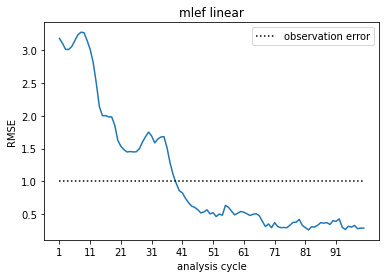

In [8]:
obs_s = sigma[op]
x = np.arange(na) + 1
y = np.ones(x.size) * obs_s
fig, ax = plt.subplots()
ax.plot(x, e)
ax.plot(x, y, linestyle="dotted", color="black", label="observation error")
ax.set(xlabel="analysis cycle", ylabel="RMSE", title=pt+" "+op)
ax.set_xticks(x[::10])
ax.set_xticks(x[::20],minor=True)
ax.legend()
plt.show()